# Procesamiento de Imágenes - Trabajos Prácticos
## Optativa de la Diplomatura en Ciencia de Datos 2023, FaMAF, UNC

Integrantes del grupo: Jerónimo Fotinós, Candelaria Bosch, Felipe Gonzales

(Se intentará mantener el [estilo de documentación de NumPy](https://numpydoc.readthedocs.io/en/latest/format.html), usar indicaciones de tipo, y `black` para el estilo del código.)

In [1]:
# ---- Imports ----

from typing import Optional, Union

import cv2
import numpy as np
import matplotlib.pyplot as plt

## Ejercicio 1.1
La propuesta para esta actividad consiste en manipular independientemente la
luminancia y la saturación de una imagen.
Para ello convertimos cada pixel de la imagen del espacio RGB al espacio YIQ, luego
alteramos los valores de Y (para cambiar la luminancia) o de IQ (para cambiar la
saturación).
Con los nuevos valores de YIQ, convertimos a RGB nuevamente y obtenemos una
nueva imagen.

Podríamos llamar $\alpha$ al coeficiente de luminancia (si es menor que uno, baja la luminancia, y viceversa), y $\beta$ al coeficiente de saturación (si es menor que uno baja la saturación, y viceversa). El workflow a implementar consiste en los siguientes pasos:
1. Normalizar los valores de RGB del pixel
2. RGB -> YIQ (utilizando la segunda matriz)
3. $Y’ := \alpha Y$ ;
4. $I’ := \beta I ; Q’ := \beta Q$ ;
5. Chequear que $Y’ <= 1$ (para que no se vaya de rango)
6. Chequear $-0.5957 < I’ < 0.5957$ y $-0.5226 < Q’ < 0.5226$
7. Y’I’Q’ -> R’G’B’ (el RGB normalizado del pixel procesado)
8. Convertir R’G’B’ a bytes y graficar el pixel


¿Qué podemos esperar al cambiar $\alpha$ o $\beta$? Como dijimos, un valor de a menor que 1 reducirá la luminancia de la imagen.

Un valor de $\alpha$ mayor que 1 aumenta la luminancia de la imagen, pero no podemos pasar el valor Y=1, lo cual genera “artefactos”.

Valores de $\beta$ menores que 1 disminuyen la saturación (inclusive lleva la imagen a blanco y negro). Valores de $\beta$ mayores que 1 aumentan la saturación.



In [2]:
# ---- For reading an image ----


def read_image(
    file_path: str, color_conversion: Optional[int] = cv2.COLOR_BGR2RGB
) -> Optional[np.ndarray]:
    """
    Reads an image from the file path and converts its color space.

    Parameters
    ----------
    file_path : str
        Path to the image file to be read.
    color_conversion : int, optional
        OpenCV color conversion code. Default is cv2.COLOR_BGR2RGB.

    Returns
    -------
    np.ndarray or None
        The image in the specified color space if successful, or None if the image could not be read.
    """
    image = cv2.imread(file_path)

    if image is None:
        print(f"Error: Could not read image from {file_path}")
        return None

    image_converted = cv2.cvtColor(image, color_conversion)

    return image_converted

In [3]:
# ---- Converting from bytes to the [0,1] range ----


def convert_color_range(image: np.ndarray, inverse: bool = False) -> np.ndarray:
    """
    Convert the color range of the image between [0, 255] and [0, 1].

    Parameters
    ----------
    image : numpy.ndarray
        The input image with shape (height, width, 3) for color images.
    inverse : bool, optional
        Flag to indicate the direction of conversion.
        - False (default): Convert from [0, 255] to [0, 1]
        - True: Convert from [0, 1] to [0, 255]

    Returns
    -------
    numpy.ndarray
        The image after converting its color range.
    """
    if not inverse:
        return image / 255.0
    else:
        return (image * 255).astype(np.uint8)

In [4]:
# ---- Color space transformation ----


def convert_RGB_to_YIQ(image: np.ndarray, inverse: bool = False) -> np.ndarray:
    """
    Convert the color space of the image between RGB and YIQ.

    Parameters
    ----------
    image : numpy.ndarray
        The input image with shape (height, width, 3) for color images.
    inverse : bool, optional
        Flag to indicate the direction of conversion.
        - False (default): Convert from RGB to YIQ
        - True: Convert from YIQ to RGB

    Returns
    -------
    numpy.ndarray
        The image after converting its color space.
    """
    if not inverse:
        # RGB to YIQ
        conversion_matrix = np.array(
            [
                [0.299, 0.587, 0.114],
                [0.595716, -0.274453, -0.321263],
                [0.211456, -0.522591, 0.311135],
            ]
        )
    else:
        # YIQ to RGB
        conversion_matrix = np.array(
            [[1.0, 0.9563, 0.6210], [1.0, -0.2721, -0.6474], [1.0, -1.1070, 1.7046]]
        )

    # we reshape the image to be a 2D array where each row is a color triplet
    reshaped_image = image.reshape(-1, 3)

    # we perform the matrix multiplication
    converted_image = np.dot(reshaped_image, conversion_matrix.T)

    # we reshape back to the original image dimensions
    converted_image = converted_image.reshape(image.shape)

    return converted_image

In [5]:
# ---- Validate the range of the variables, to be used later ----


def validate_YIQ(image_yiq: np.ndarray, method: str = "clamping") -> np.ndarray:
    """
    Validates the YIQ values to ensure they are within the valid ranges.

    Parameters
    ----------
    image_yiq : np.ndarray
        The input YIQ image with shape (height, width, 3).
    method : str, optional
        The method to use for correcting out-of-range values.
        Default is 'clamping'.

    Returns
    -------
    np.ndarray
        The YIQ image with values corrected to be within the valid ranges.
    """
    if method == "clamping":
        image_yiq[..., 0] = np.clip(image_yiq[..., 0], 0, 1)
        image_yiq[..., 1] = np.clip(image_yiq[..., 1], -0.5957, 0.5957)
        image_yiq[..., 2] = np.clip(image_yiq[..., 2], -0.5226, 0.5226)
    else:
        raise ValueError(f"Method {method} is not implemented.")

    return image_yiq

In [6]:
# ---- Multiplying by alpha and beta ----


def edit_brightness_and_saturation(
    image: np.ndarray,
    brightness_factor: float = 1,
    saturation_factor: float = 1,
    validate_method: str = "clamping",
) -> np.ndarray:
    """
    Adjusts the brightness and saturation of an image in RGB color space.

    Parameters
    ----------
    image : np.ndarray
        The input RGB image with shape (height, width, 3).
    brightness_factor : float
        Factor to adjust the Y channel for brightness. Defaults to 1.
    saturation_factor : float
        Factor to adjust the I and Q channels for saturation. Defaults to 1.
    validate_method : str, optional
        The method to use for correcting out-of-range YIQ values.
        Default is 'clamping'.

    Returns
    -------
    np.ndarray
        The RGB image after adjusting its brightness and saturation.
    """
    # Convert RGB range to [0, 1]
    image_normalized = convert_color_range(image)

    # Convert from RGB to YIQ
    image_yiq = convert_RGB_to_YIQ(image_normalized)

    # Modify Y, I, Q channels
    image_yiq[..., 0] *= brightness_factor
    image_yiq[..., 1:] *= saturation_factor

    # Validate YIQ values
    image_yiq = validate_YIQ(image_yiq, method=validate_method)

    # Convert back to RGB from YIQ
    image_rgb_normalized = convert_RGB_to_YIQ(image_yiq, inverse=True)

    # Convert back to original RGB range [0, 255]
    image_rgb = convert_color_range(image_rgb_normalized, inverse=True)

    return image_rgb

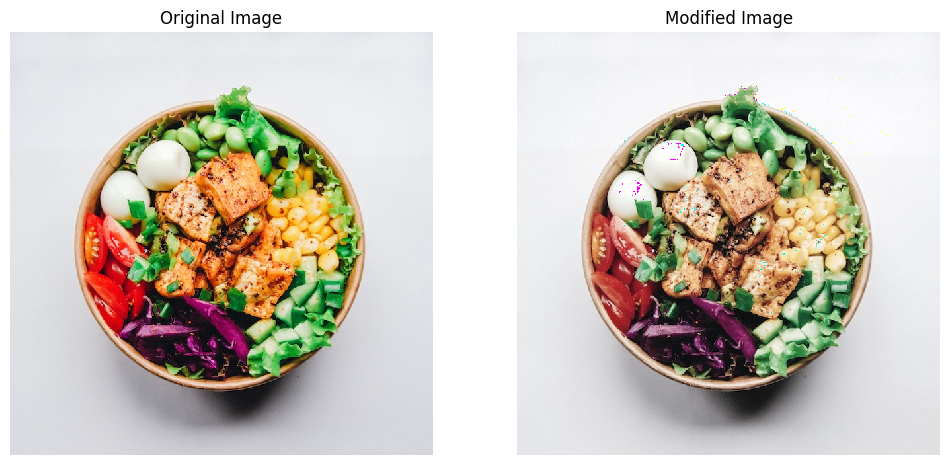

In [12]:
# ---- Actually using the previous functions ----

# we read and convert the image to RGB using read_image function
image_rgb = read_image("images/bowl.jpg")

# we check if the image was read successfully
if image_rgb is not None:
    # we edit brightness and saturation, obtaining a new RGB image
    image_rgb_modified = edit_brightness_and_saturation(image_rgb, 1.05, 0.6)

    # Plot the modified image
    # plt.imshow(image_rgb_modified)
    # plt.axis('off')  # Turn off axis numbers and ticks
    # plt.title('Modified Image')
    # plt.show()

    # Create a figure and a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axs[0].imshow(image_rgb, interpolation="nearest")  # 'nearest' avoids interpolation
    axs[0].axis("off")
    axs[0].set_title("Original Image")

    # Display the modified image
    axs[1].imshow(
        image_rgb_modified, interpolation="nearest"
    )  # 'nearest' avoids interpolation
    axs[1].axis("off")
    axs[1].set_title("Modified Image")

    # Show the plot
    plt.show()

Podemos ver como la imagen está efectivamente más birllante y con menos saturación. En los lugares más brillantes de la imagen se nota el efecto del clampping, ya que aparecieron pixeles cuya cromaticidad cambió. Esto se debe a que al reemplazar un valor que excede el máximo posible por dicho máximo, las proporciones de cada color cambian, cambiando la cromaticidad.

También podemos llevar la imagen a blanco y negro, tomando $\beta=0$.

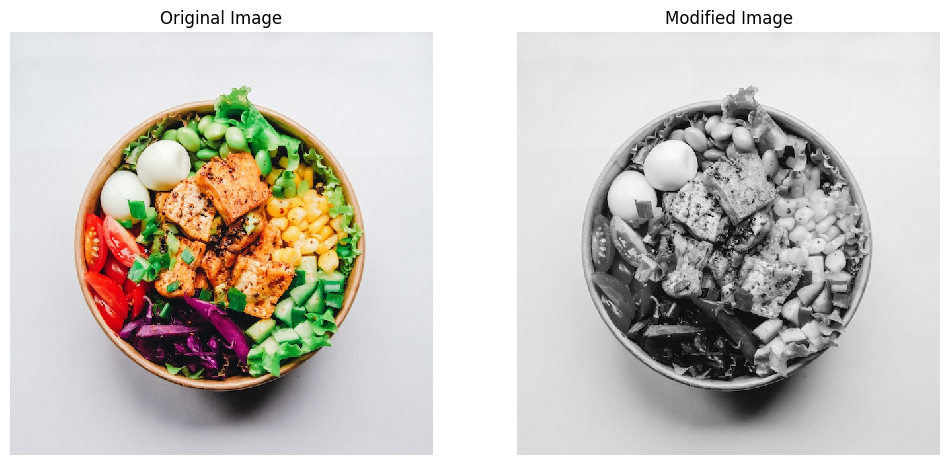

In [31]:
# ---- Block of code for reading and editing the image ----

# we read and convert the image to RGB using read_image function
image_rgb = read_image("images/bowl.jpg")

# we check if the image was read successfully
if image_rgb is not None:
    # we edit brightness and saturation, obtaining a new RGB image
    image_rgb_modified = edit_brightness_and_saturation(image_rgb, 1.0, 0.0)

    # Plot the modified image
    # plt.imshow(image_rgb_modified)
    # plt.axis('off')  # Turn off axis numbers and ticks
    # plt.title('Modified Image')
    # plt.show()

    # Create a figure and a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axs[0].imshow(image_rgb, interpolation="nearest")  # 'nearest' avoids interpolation
    axs[0].axis("off")
    axs[0].set_title("Original Image")

    # Display the modified image
    axs[1].imshow(
        image_rgb_modified, interpolation="nearest"
    )  # 'nearest' avoids interpolation
    axs[1].axis("off")
    axs[1].set_title("Modified Image")

    # Show the plot
    plt.show()

Hagamos ahora el caso contrario, bajemos la luminancia y subamos la saturación.

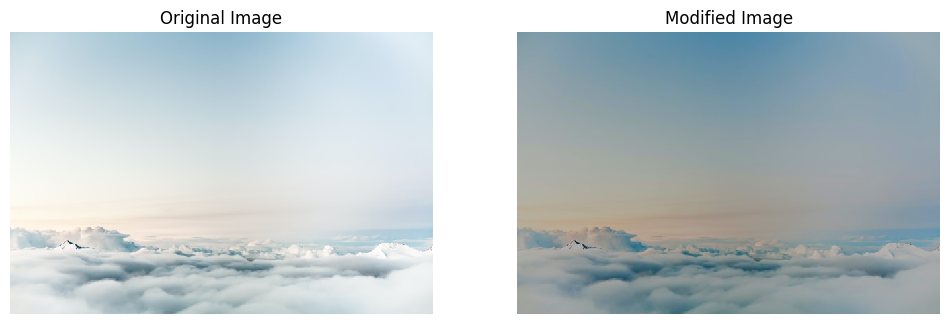

In [33]:
# ---- Block of code for reading and editing the image ----

# we read and convert the image to RGB using read_image function
image_rgb = read_image("images/clouds.jpg")

# we check if the image was read successfully
if image_rgb is not None:
    # we edit brightness and saturation, obtaining a new RGB image
    image_rgb_modified = edit_brightness_and_saturation(image_rgb, 0.7, 1.5)

    # Plot the modified image
    # plt.imshow(image_rgb_modified)
    # plt.axis('off')  # Turn off axis numbers and ticks
    # plt.title('Modified Image')
    # plt.show()

    # Create a figure and a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axs[0].imshow(image_rgb, interpolation="nearest")  # 'nearest' avoids interpolation
    axs[0].axis("off")
    axs[0].set_title("Original Image")

    # Display the modified image
    axs[1].imshow(
        image_rgb_modified, interpolation="nearest"
    )  # 'nearest' avoids interpolation
    axs[1].axis("off")
    axs[1].set_title("Modified Image")

    # Show the plot
    plt.show()

Acá vemos claramente como el brillo bajó, pues usamos $\alpha<1$, mientras que la saturación aumentó, debido a haber usado $\beta>1$.

Nota: la imagen anterior del bowl de comida estaba ya muy saturada, por lo que usarla para este ejemplo resultaba en una distorsión muy agresiva debida al clamping. Por esto se decidió usar una foto que en su versión original estuviera más “lavada”.

---

En la consigna del práctico pregunta qué valores de $\alpha$ y $\beta$ creemos que tienen el par de imágenes de la derecha (la de la izquierda es la original).

![alternative text](images/charlies.png)

Es claro que en el caso de la primera imagen modificada, el brillo ha aumentado, mientras que en el caso de la segunda ha disminuido. También parece haber aumentado la saturación en la primera imagen y disminuido en la segunda. Probemos si esto es así.


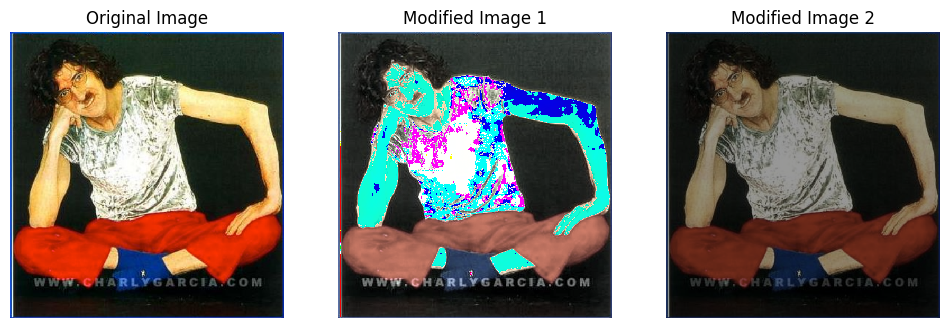

In [68]:
# ---- Block of code for reading and editing the image ----

# we read and convert the image to RGB using read_image function
image_rgb = read_image("images/charlie.png")

# we check if the image was read successfully
if image_rgb is not None:
    # we edit brightness and saturation, obtaining a new RGB image
    image_rgb_modified1 = edit_brightness_and_saturation(image_rgb, 1.4, 0.4)
    image_rgb_modified2 = edit_brightness_and_saturation(image_rgb, 0.6, 0.35)

    # Plot the modified image
    # plt.imshow(image_rgb_modified)
    # plt.axis('off')  # Turn off axis numbers and ticks
    # plt.title('Modified Image')
    # plt.show()

    # Create a figure and a 1x3 grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image
    axs[0].imshow(image_rgb, interpolation="nearest")  # 'nearest' avoids interpolation
    axs[0].axis("off")
    axs[0].set_title("Original Image")

    # Display the modified image 1
    axs[1].imshow(
        image_rgb_modified1, interpolation="nearest"
    )  # 'nearest' avoids interpolation
    axs[1].axis("off")
    axs[1].set_title("Modified Image 1")

    # Display the modified image 2
    axs[2].imshow(
        image_rgb_modified2, interpolation="nearest"
    )  # 'nearest' avoids interpolation
    axs[2].axis("off")
    axs[2].set_title("Modified Image 2")

    # Show the plot
    plt.show()

Es claro que la imagen modificada número 2, nuestra intuición va bien encaminada; la imagen producida aquí y la del enunciado del ejercicio (mostrada en la celda de texto de más arriba) son bastante parecidas. Sin embargo, en el caso de la primera imagen modificada no se logró todavía una imagen cercana. Puede verse cómo la manipulación puede hacer notorios los artefactos de la compresión en la imagen original. Una primera hipótesis sobre el porqué de esta diferencia, podría ser la manera de manejar los pixeles que exceden los valores permitidos de alguna componente. Si este fuera el caso, tendríamos que implementar y utilizar un método diferente a `'clamping'` en la función `validate_YIQ`.

## Ejercicio 1.2

Desarrollar un aplicativo que pueda abrir una imagen, manipule su histograma de luminancias, y luego ver la imagen procesada. Se debe poder elegir filtro raíz, cuadrado, o lineal a trozos. Los controles para elegir los filtros los organizan como les resulte más cómodo.

## Ejercicio 1.3 (optativo)
La propuesta para esta actividad consiste en utilizar algunos datasets 2D (pueden ser
mapas de altitud, de temperatura, etc.) y “visualizarlos” con diferentes paletas,
incluyendo la de niveles de gris y la arco iris.

## Ejercicio 1.4 (optativo)

Implementar un aplicativo que ejecute las operaciones vistas en este tema (álgebra de pixels). Se muestra la interfaz gráfica de un ejemplo en particular de superposición de imágenes.